# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 10.0.0.10001044
-- The CXX compiler identification is AppleClang 10.0.0.10001044
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /opt/anaconda3/bin/python (found version "3.7.6") 
-- Found PythonLibs: /opt/anaconda3/lib/libpython3.7m.dylib
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing 

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/Users/celeste/facultad/metodos/metnum-tp2/notebooks
Python 3.7.6


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [7]:
c = df_train.sample(frac=1)
c = c[:10000]
c

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34756,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13781,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41855,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7688,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11048,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29598,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30691,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19680,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38739,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [8]:
# Uso values para mandar todo a arrays de numpy

X = c[c.columns[1:]].values
y = c["label"].values.reshape(-1, 1)

X.shape, y.shape


((10000, 784), (10000, 1))

### Conjunto de development

In [34]:
%%time
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import time
def do_knn(upper_bound,start, steps, x_train, x_labels, x_val, y_val):
    i = start
    ks = np.empty(0, dtype='d')
    ac = np.empty(0, dtype='d')
    rc = np.empty(0, dtype='d')
    tm = np.empty(0, dtype='d')
    pc = np.empty(0, dtype='d')
    while i <= upper_bound:
      start = time.time()
      clf = metnum.KNNClassifier(i)
      clf.fit(x_train, x_labels)
      y_pred = clf.predict(x_val)
      end = time.time()
      ac_score = accuracy_score(y_val, y_pred)
      rc_score = recall_score(y_val, y_pred, labels = [0,1,2,3,4,5,6,7,8,9], average='macro')
      prec_score = precision_score(y_val, y_pred, labels = [0,1,2,3,4,5,6,7,8,9], average='macro')
      ac = np.append(ac, ac_score)
      rc = np.append(rc, rc_score)
      pc = np.append(pc, prec_score)
      ks = np.append(ks, i+1)
      tm = np.append(tm, (end-start)/60)
      i = i + steps
    return ks, ac, rc, tm, pc
    

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 19.8 µs


In [35]:
%%time
from sklearn.model_selection import StratifiedKFold, GroupKFold
z = y.flatten()
splits = 5
group_kfold = StratifiedKFold(n_splits=splits)
start = 1
steps = 10
upper_bound_knn = 201
vectors_size = 21
ks = np.zeros(vectors_size)
ac = np.zeros(vectors_size)
rc = np.zeros(vectors_size)
tm = np.zeros(vectors_size)
pc = np.zeros(vectors_size)

for train_index, test_index in group_kfold.split(X, z):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ks_i, ac_i, rc_i, tm_i, pc_i = do_knn(upper_bound_knn, start, steps, X_train, y_train, X_test, y_test)
    ks = ks + ks_i
    ac = ac + ac_i
    rc = rc + rc_i
    tm = tm + tm_i
    pc = pc + pc_i
    
ks_m = ks/splits
ac_m = ac/splits
rc_m = rc/splits
tm_m = tm/splits
pc_m = pc/splits

print(ac_m)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8587 0.857  0.8488 0.8411 0.8343 0.8282 0.8229 0.8183 0.8131 0.8096
 0.8066 0.8018 0.7994 0.7963 0.7921 0.7883 0.785  0.7821 0.7792 0.7761
 0.7736]
CPU times: user 26min 58s, sys: 30.4 s, total: 27min 28s
Wall time: 29min 38s


In [50]:
print(tm_m)

[0.27607114 0.28399377 0.28378302 0.28475297 0.28038297 0.28444977
 0.27386602 0.28898377 0.28033249 0.28120794 0.2791953  0.28809517
 0.29179867 0.29823576 0.29059838 0.27956693 0.2862834  0.26655079
 0.26604874 0.2736749  0.28719826]


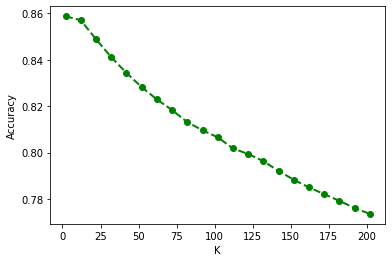

In [51]:
import matplotlib.pyplot as plt
plt.plot(ks_m, ac_m, color='green', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.savefig('10000accuracyKNN.png')

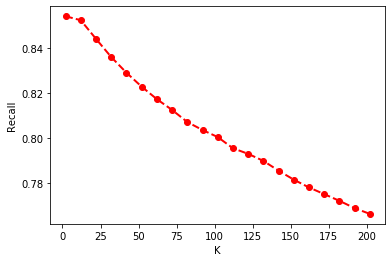

In [52]:
plt.plot(ks_m, rc_m, color='red', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Recall')
plt.xlabel('K')
plt.savefig('10000recallKNN.png')

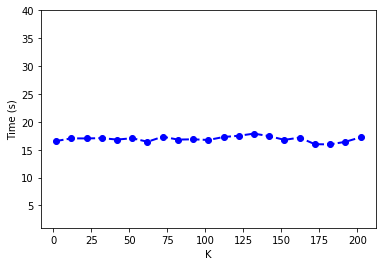

In [57]:
tm_m_s = tm_m*60
plt.plot(ks_m, tm_m_s, color='blue', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Time (s)')
plt.xlabel('K')
plt.ylim((1, 40))
plt.savefig('10000timeKNN.png')

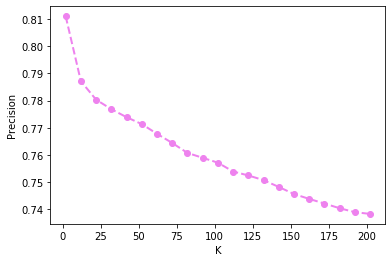

In [54]:
plt.plot(ks_m, pc_m, color='violet', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Precision')
plt.xlabel('K')
plt.savefig('10000precisionKNN.png')

In [55]:
print(ks_m)

[  2.  12.  22.  32.  42.  52.  62.  72.  82.  92. 102. 112. 122. 132.
 142. 152. 162. 172. 182. 192. 202.]


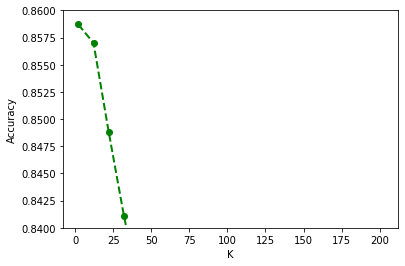

In [56]:
import matplotlib.pyplot as plt
plt.plot(ks_m, ac_m, color='green', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.ylim((0.84, 0.86))
plt.savefig('10000accuracyRecorteKNN.png')